# GASI: Game Advantage State Identification (Chess Version)

A small game between a classical, quantum, and human player to identify whether a Blue or Red player is winning a game. Makes use of nearest centroid classification on the game of chess

_**If you want to play the game, then run all cells and [proceed to the bottom of the notebook](#Play-the-Game!)**_

#### This is team-specific (skip, since you won't have access to these files)

In [ ]:
# Mount google drive location
from google.colab import drive
drive.mount('/content/drive')

# Qiskit Setup
!pip install qiskit drive/MyDrive/iQuHACK2021/Data/qiskit_ionq_provider-0.0.1.dev0+45bd6b1-py3-none-any.whl

### Setup

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from IPython.display import clear_output
import pandas as pd
# =======================================================
import math
import time
from qiskit import Aer, QuantumCircuit, execute
from qiskit.extensions import UnitaryGate
from qiskit.providers.jobstatus import JobStatus
import cv2

In [ ]:
# Use Aer's qasm_simulator by default
backend = Aer.get_backend('qasm_simulator')

#### If you have access to the IonQ Provider run this cell

In [ ]:
import os

try:
    from qiskit_ionq_provider import IonQProvider 

    key_path = "/content/drive/MyDrive/iQuHACK2021/Data/qriket_key"
    alt_key_path = "qriket_key"
    if os.path.isfile(key_path):
        with open(key_path, 'r') as file:
            key = file.read().replace('\n', '')
    elif os.path.isfile(alt_key_path):
        with open(alt_key_path, 'r') as file:
            key = file.read().replace('\n', '')
    else:
        key = input("Enter your IonQ Token").lower()

    # Call provider and set token value
    provider = IonQProvider(key)
    backend = provider.get_backend("ionq_simulator")

    # Uncomment and use this line instead if you want to use REAL hardware
    # backend = provider.get_backend("ionq_qpu")
    
except:
    print("IonQ package not installed")

### Data Generation for Sample Boards

In [9]:
# generate chess board data: random 8 x 8 board
def generate_chess():
    '''
    Generates a random board of dimensions 8 x 8

    Outputs:
    board      := flattened 8 x 8 array
    winner     := red wins == 1, blue wins == -1
    sum_red    := sum of red pieces
    sum_blue   := sum of blue pieces
    '''
    board=np.zeros((8*8))
    board_label=np.zeros((8*8)).astype(object)
    # Assign chess piece point values, names, max pieces per board
        # dictionary key:  {'name':[points, max_pieces]}
    piece_list_w=['pawn_w','knight_w','bishop_w','rook_w','queen_w','king_w']
    piece_list_b=['pawn_b','knight_b','bishop_b','rook_b','queen_b','king_b']
    chess_values_w = {'pawn_w':[1,8],'knight_w':[3,2],'bishop_w':[3,2],'rook_w':[5,2],'queen_w':[9,1],'king_w':[40,1]}
    chess_values_b = {'pawn_b':[1,8],'knight_b':[3,2],'bishop_b':[3,2],'rook_b':[5,2],'queen_b':[9,1],'king_b':[40,1]}
    # generate random number of chess pieces with bounds for white and black (there must be at least a king for each side)
    piece_locations_white=np.zeros((len(piece_list_w),3)).astype(object)
    piece_locations_black=np.zeros((len(piece_list_b),3)).astype(object)
    piece_locations_white[0]=['king_w',chess_values_w['king_w'][0],chess_values_w['king_w'][1]]
    piece_locations_black[0]=['king_b',chess_values_b['king_b'][0],chess_values_b['king_b'][1]]
    for n in range(len(piece_list_w)-1): # skip king because there must be a king
        points_w,max_pieces_w=chess_values_w[piece_list_w[n]]
        points_b,max_pieces_b=chess_values_b[piece_list_b[n]]
        piece_locations_white[n+1,:]=[piece_list_w[n],points_w,random.sample(range(0,max_pieces_w+1),1)[0]]
        piece_locations_black[n+1,:]=[piece_list_b[n],points_b,random.sample(range(0,max_pieces_b+1),1)[0]]
    black_pieces=int(np.sum(piece_locations_black[:,2])) # count black pieces
    white_pieces=int(np.sum(piece_locations_white[:,2])) # count white pieces
    total_pieces=black_pieces+white_pieces # total number of pieces on the board
    all_piece_locations=random.sample(range(0,8*8),total_pieces)
    index=0
    for n in range(len(piece_list_b)):  # black piece location assignment
        for p in range(piece_locations_black[n,2]):
            board[all_piece_locations[index]]= piece_locations_black[n,1] # populate with piece value
            board_label[all_piece_locations[index]]= piece_locations_black[n,0] # populate with piece name
            index+=1
    for n in range(len(piece_list_w)): # white piece location assignment
        for p in range(piece_locations_white[n,2]):
            board[all_piece_locations[index]]= -piece_locations_white[n,1] # populate with piece value
            board_label[all_piece_locations[index]]= piece_locations_white[n,0] # populate with piece name
            index+=1
    sum_black=np.sum(piece_locations_black[:,1]*piece_locations_black[:,2])
    sum_white=np.sum(piece_locations_white[:,1]*piece_locations_white[:,2])
    return board, board_label, sum_black, sum_white

In [22]:
def chessBoardShow(chessBoard):
    chessBoard = chessBoard.reshape(8, 8)

    filepath='meta/chess/B.Knight.png'
    kb=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/B.Bish.png'
    bb=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/B.Quee.png'
    qb=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/B.Rook.png'
    rb=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/B.Pawn.png'
    pb=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/B.King.png'
    kib=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)

    filepath='meta/chess/W.Knight.png'
    kw=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/W.Bish.png'
    bw=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/W.Quee.png'
    qw=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/W.Rook.png'
    rw=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/W.Pawn.png'
    pw=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    filepath='meta/chess/W.King.png'
    kiw=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)

    filepath='meta/chess/trans.png'
    trans=cv2.imread(filepath,cv2.IMREAD_UNCHANGED)

    chessPiece = {
        "knight_b":kb,
        "bishop_b": bb,
        "queen_b": qb,
        "rook_b": rb,
        "pawn_b": pb,
        "king_b": kib,
        "knight_w": kw,
        "bishop_w": bw,
        "queen_w": qw,
        "rook_w": rw,
        "pawn_w": pw,
        "king_w": kiw,
        0.0: trans
    }

    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 

    def pictureSelect(n,m):
        try:
            dictPiece = chessPiece[chessBoard[n][m]]
            if dictPiece != trans:
                ax[n,m].imshow(dictPiece,cmap='bone')
        except (Exception):
            pass
    fig,ax=plt.subplots(figsize=(8,1))
    ax.set_facecolor('grey')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.2,0.2,'Black Side',fontsize=45,c='w')
    plt.show()
    fig,ax=plt.subplots(ncols=8,nrows=8,figsize=(8,8))

    for n in range(8):
        for m in range(8):
            count = 0
            if (m % 2 != 0):
                count += 1
            if ((n % 2) == 0):
                count += 1
            if count == 2:
                ax[n,m].set_facecolor('grey')
            count = 0
            if (m % 2 == 0):
                count += 1
            if ((n % 2) != 0):
                count += 1
            if count == 2:
                ax[n,m].set_facecolor('grey')
            ax[n,m].set_xticks([])
            ax[n,m].set_yticks([])
            pictureSelect(n,m)
    fig,ax=plt.subplots(figsize=(8,1))
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.2,0.2,'White Side',fontsize=45,c='k')
    plt.show()

In [23]:
def generate_best_move():
    # create a board and make sure kings are at least 11 spaces away from each other
    board, board_label, sum_black, sum_white=generate_chess() # generate board
    king_b=np.where(board_label=='king_b')[0][0]
    king_w=np.where(board_label=='king_w')[0][0]
    while np.abs(king_b-king_w) < 11:
        board, board_label, sum_black, sum_white=generate_chess()
        king_b=np.where(board_label=='king_b')[0][0]
        king_w=np.where(board_label=='king_w')[0][0]
    
    board_label_sq=board_label.reshape(8,8)
     # Assign chess piece point values, names, max pieces per board
        # dictionary key:    {'name':[points, max_pieces]}
    piece_list_w=np.array(['pawn_w','knight_w','bishop_w','rook_w','queen_w','king_w'])
    piece_list_b=np.array(['pawn_b','knight_b','bishop_b','rook_b','queen_b','king_b'])
    chess_values_w = {'pawn_w':[1,8],'knight_w':[3,2],'bishop_w':[3,2],'rook_w':[5,2],'queen_w':[9,1],'king_w':[40,1]}
    chess_values_b = {'pawn_b':[1,8],'knight_b':[3,2],'bishop_b':[3,2],'rook_b':[5,2],'queen_b':[9,1],'king_b':[40,1]}

    # white starts on the bottom for our board
    white_scores=[]
    black_scores=[]
    # we have to iterate on every piece to see what the best legal move is that gets the highest point value
    for n in range(8): # rows
        for m in range(8): # columns
            # =========================================
            if board_label_sq[n,m]=='pawn_w': # white pawn
                take1 = 0.0
                take2 = 0.0
                take3 = 0.0
                take4 = 0.0
                pawn_w_take=[0]
                if m==0 and n>0:
                    take1 = board_label_sq[n-1,m+1] # col 0, row +1
                elif 7>m>0 and n>0:
                    take2 = board_label_sq[n-1,m+1] # col 0-6, row +1
                    take3 = board_label_sq[n-1,m-1] # col 0-6, row -1
                elif m==7 and n>0:
                    take4 = board_label_sq[n-1,m-1] # col 7, row -1
                if take1!=0 and np.sum(take1==piece_list_b)>0:
                    pawn_w_take.append(chess_values_b[take1][0])
                if take2!=0 and np.sum(take2==piece_list_b)>0:
                    pawn_w_take.append(chess_values_b[take2][0])
                if take3!=0 and np.sum(take3==piece_list_b)>0:
                    pawn_w_take.append(chess_values_b[take3][0])
                if take4!=0 and np.sum(take4==piece_list_b)>0:
                    pawn_w_take.append(chess_values_b[take4][0])
                else:
                    pass
                white_scores.append(np.max(pawn_w_take))
            # =========================================
            elif board_label_sq[n,m]=='pawn_b': # black pawn
                take1 = 0.0
                take2 = 0.0
                take3 = 0.0
                take4 = 0.0
                pawn_b_take=[0]
                if m==0 and n<7:
                    take1 = board_label_sq[n+1,m+1] # col 0, row +1
                elif 7>m>0 and n<7:
                    take2 = board_label_sq[n+1,m+1] # col 0-6, row +1
                    take3 = board_label_sq[n+1,m-1] # col 0-6, row -1
                elif m==7 and n<7:
                    take4 = board_label_sq[n+1,m-1] # col 7, row -1
                if take1!=0 and np.sum(take1==piece_list_w)>0:
                    pawn_b_take.append(chess_values_w[take1][0])
                if take2!=0 and np.sum(take2==piece_list_w)>0:
                    pawn_b_take.append(chess_values_w[take2][0])
                if take3!=0 and np.sum(take3==piece_list_w)>0:
                    pawn_b_take.append(chess_values_w[take3][0])
                if take4!=0 and np.sum(take4==piece_list_w)>0:
                    pawn_b_take.append(chess_values_w[take4][0])
                else:
                    pass
                black_scores.append(np.max(pawn_b_take))
            # =========================================
            elif board_label_sq[n,m]=='bishop_w': # white bishop
                take1=0.0
                take2=0.0
                take3=0.0
                take4=0.0
                bishop_w_take=[0]
                for bishw in range(7):
                    if n+bishw<7 and m+bishw<7:
                        take1 = board_label_sq[n+bishw+1,m+bishw+1] # col +1, row +1
                    if take1!=0:
                        break
                for bishw in range(7):
                    if n+bishw<7 and m-bishw>0:
                        take2 = board_label_sq[n+bishw+1,m-bishw-1] # col -1, row +1
                    if take2!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m+bishw<7:
                        take3 = board_label_sq[n-bishw-1,m+bishw+1] # col +1, row -1
                    if take3!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m-bishw>0:
                        take4 = board_label_sq[n-bishw-1,m-bishw-1] # col -1, row -1
                    if take4!=0:
                        break
                if take1!=0 and np.sum(take1==piece_list_b)>0:
                    bishop_w_take.append(chess_values_b[take1][0])
                if take2!=0 and np.sum(take2==piece_list_b)>0:
                    bishop_w_take.append(chess_values_b[take2][0])
                if take3!=0 and np.sum(take3==piece_list_b)>0:
                    bishop_w_take.append(chess_values_b[take3][0])
                if take4!=0 and np.sum(take4==piece_list_b)>0:
                    bishop_w_take.append(chess_values_b[take4][0])
                else:
                    pass
                white_scores.append(np.max(bishop_w_take))
                        # =========================================
            elif board_label_sq[n,m]=='bishop_b': # black bishop
                take1=0.0
                take2=0.0
                take3=0.0
                take4=0.0
                bishop_b_take=[0]
                for bishw in range(7):
                    if n+bishw<7 and m+bishw<7:
                        take1 = board_label_sq[n+bishw+1,m+bishw+1] # col +1, row +1
                    if take1!=0:
                        break
                for bishw in range(7):
                    if n+bishw<7 and m-bishw>0:
                        take2 = board_label_sq[n+bishw+1,m-bishw-1] # col -1, row +1
                    if take2!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m+bishw<7:
                        take3 = board_label_sq[n-bishw-1,m+bishw+1] # col +1, row -1
                    if take3!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m-bishw>0:
                        take4 = board_label_sq[n-bishw-1,m-bishw-1] # col -1, row -1
                    if take4!=0:
                        break
                if take1!=0 and np.sum(take1==piece_list_w)>0:
                    bishop_b_take.append(chess_values_w[take1][0])
                if take2!=0 and np.sum(take2==piece_list_w)>0:
                    bishop_b_take.append(chess_values_w[take2][0])
                if take3!=0 and np.sum(take3==piece_list_w)>0:
                    bishop_b_take.append(chess_values_w[take3][0])
                if take4!=0 and np.sum(take4==piece_list_w)>0:
                    bishop_b_take.append(chess_values_w[take4][0])
                else:
                    pass
                black_scores.append(np.max(bishop_b_take))
            # =========================================
            elif board_label_sq[n,m]=='rook_w': # white rook
                take1=0.0
                take2=0.0
                take3=0.0
                take4=0.0
                rook_w_take=[0]
                for bishw in range(7):
                    if n+bishw<7:
                        take1 = board_label_sq[n+bishw+1,m] # col 0, row +1
                    if take1!=0:
                        break
                for bishw in range(7):
                    if m-bishw>0:
                        take2 = board_label_sq[n,m-bishw-1] # col -1, row 0
                    if take2!=0:
                        break
                for bishw in range(7):
                    if m+bishw<7:
                        take3 = board_label_sq[n,m+bishw+1] # col +1, row 0
                    if take3!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0:
                        take4 = board_label_sq[n-bishw-1,m] # col 0, row -1
                    if take4!=0:
                        break
                if take1!=0 and np.sum(take1==piece_list_b)>0:
                    rook_w_take.append(chess_values_b[take1][0])
                if take2!=0 and np.sum(take2==piece_list_b)>0:
                    rook_w_take.append(chess_values_b[take2][0])
                if take3!=0 and np.sum(take3==piece_list_b)>0:
                    rook_w_take.append(chess_values_b[take3][0])
                if take4!=0 and np.sum(take4==piece_list_b)>0:
                    rook_w_take.append(chess_values_b[take4][0])
                else:
                    pass
                white_scores.append(np.max(rook_w_take))
            # =========================================
            elif board_label_sq[n,m]=='rook_b': # black rook
                take1=0.0
                take2=0.0
                take3=0.0
                take4=0.0
                rook_b_take=[0]
                for bishw in range(7):
                    if n+bishw<7:
                        take1 = board_label_sq[n+bishw+1,m] # col 0, row +1
                    if take1!=0:
                        break
                for bishw in range(7):
                    if m-bishw>0:
                        take2 = board_label_sq[n,m-bishw-1] # col -1, row 0
                    if take2!=0:
                        break
                for bishw in range(7):
                    if m+bishw<7:
                        take3 = board_label_sq[n,m+bishw+1] # col +1, row 0
                    if take3!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0:
                        take4 = board_label_sq[n-bishw-1,m] # col 0, row -1
                    if take4!=0:
                        break
                if take1!=0 and np.sum(take1==piece_list_w)>0:
                    rook_b_take.append(chess_values_w[take1][0])
                if take2!=0 and np.sum(take2==piece_list_w)>0:
                    rook_b_take.append(chess_values_w[take2][0])
                if take3!=0 and np.sum(take3==piece_list_w)>0:
                    rook_b_take.append(chess_values_w[take3][0])
                if take4!=0 and np.sum(take4==piece_list_w)>0:
                    rook_b_take.append(chess_values_w[take4][0])
                else:
                    pass
                black_scores.append(np.max(rook_b_take))
            # =========================================
            elif board_label_sq[n,m]=='queen_w': # white queen
                take1=0.0
                take2=0.0
                take3=0.0
                take4=0.0
                take5=0.0
                take6=0.0
                take7=0.0
                take8=0.0
                queen_w_take=[0]
                for bishw in range(7):
                    if n+bishw<7:
                        take1 = board_label_sq[n+bishw+1,m] # col 0, row +1
                    if take1!=0:
                        break
                for bishw in range(7):
                    if m-bishw>0:
                        take2 = board_label_sq[n,m-bishw-1] # col -1, row 0
                    if take2!=0:
                        break
                for bishw in range(7):
                    if m+bishw<7:
                        take3 = board_label_sq[n,m+bishw+1] # col +1, row 0
                    if take3!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0:
                        take4 = board_label_sq[n-bishw-1,m] # col 0, row -1
                    if take4!=0:
                        break
                for bishw in range(7):
                    if n+bishw<7 and m+bishw<7:
                        take5 = board_label_sq[n+bishw+1,m+bishw+1] # col +1, row +1
                    if take5!=0:
                        break
                for bishw in range(7):
                    if n+bishw<7 and m-bishw>0:
                        take6 = board_label_sq[n+bishw+1,m-bishw-1] # col -1, row +1
                    if take6!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m+bishw<7:
                        take7 = board_label_sq[n-bishw-1,m+bishw+1] # col +1, row -1
                    if take7!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m-bishw>0:
                        take8 = board_label_sq[n-bishw-1,m-bishw-1] # col -1, row -1
                    if take8!=0:
                        break
                if take1!=0 and np.sum(take1==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take1][0])
                if take2!=0 and np.sum(take2==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take2][0])
                if take3!=0 and np.sum(take3==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take3][0])
                if take4!=0 and np.sum(take4==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take4][0])
                if take5!=0 and np.sum(take5==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take5][0])
                if take6!=0 and np.sum(take6==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take6][0])
                if take7!=0 and np.sum(take7==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take7][0])
                if take8!=0 and np.sum(take8==piece_list_b)>0:
                    queen_w_take.append(chess_values_b[take8][0])
                else:
                    pass
                white_scores.append(np.max(queen_w_take))
            # =========================================
            elif board_label_sq[n,m]=='queen_b': # black queen
                take1=0.0
                take2=0.0
                take3=0.0
                take4=0.0
                take5=0.0
                take6=0.0
                take7=0.0
                take8=0.0
                queen_b_take=[0]
                for bishw in range(7):
                    if n+bishw<7:
                        take1 = board_label_sq[n+bishw+1,m] # col 0, row +1
                    if take1!=0:
                        break
                for bishw in range(7):
                    if m-bishw>0:
                        take2 = board_label_sq[n,m-bishw-1] # col -1, row 0
                    if take2!=0:
                        break
                for bishw in range(7):
                    if m+bishw<7:
                        take3 = board_label_sq[n,m+bishw+1] # col +1, row 0
                    if take3!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0:
                        take4 = board_label_sq[n-bishw-1,m] # col 0, row -1
                    if take4!=0:
                        break
                for bishw in range(7):
                    if n+bishw<7 and m+bishw<7:
                        take5 = board_label_sq[n+bishw+1,m+bishw+1] # col +1, row +1
                    if take5!=0:
                        break
                for bishw in range(7):
                    if n+bishw<7 and m-bishw>0:
                        take6 = board_label_sq[n+bishw+1,m-bishw-1] # col -1, row +1
                    if take6!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m+bishw<7:
                        take7 = board_label_sq[n-bishw-1,m+bishw+1] # col +1, row -1
                    if take7!=0:
                        break
                for bishw in range(7):
                    if n-bishw>0 and m-bishw>0:
                        take8 = board_label_sq[n-bishw-1,m-bishw-1] # col -1, row -1
                    if take8!=0:
                        break
                if take1!=0 and np.sum(take1==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take1][0])
                if take2!=0 and np.sum(take2==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take2][0])
                if take3!=0 and np.sum(take3==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take3][0])
                if take4!=0 and np.sum(take4==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take4][0])
                if take5!=0 and np.sum(take5==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take5][0])
                if take6!=0 and np.sum(take6==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take6][0])
                if take7!=0 and np.sum(take7==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take7][0])
                if take8!=0 and np.sum(take8==piece_list_w)>0:
                    queen_b_take.append(chess_values_w[take8][0])
                else:
                    pass
                black_scores.append(np.max(queen_b_take))
            # =========================================
            elif board_label_sq[n,m]=='knight_w': # white knight
                take1 = 0.0
                take2 = 0.0
                take3 = 0.0
                take4 = 0.0
                take5 = 0.0
                take6 = 0.0
                take7 = 0.0
                take8 = 0.0
                knight_w_take=[0]
                if m<7 and n<6:
                    take1 = board_label_sq[n+2,m+1] # col +1, row +2
                if m>0 and n<6:
                    take2 = board_label_sq[n+2,m-1] # col -1, row +2
                if m>0 and n>1:
                    take3 = board_label_sq[n-2,m-1] # col -1, row -2
                if m<7 and n>1:
                    take4 = board_label_sq[n-2,m+1] # col +1, row -2            
                if n<7 and m<6:
                    take5 = board_label_sq[n+1,m+2] # col +2, row +1
                if n<7 and m>1:
                    take6 = board_label_sq[n+1,m-2] # col -2, row +1
                if n>0 and m>1:
                    take7 = board_label_sq[n-1,m-2] # col -2, row -1
                if n>0 and m<6:
                    take8 = board_label_sq[n-1,m+2] # col +2, row -1        
                if take1!=0 and np.sum(take1==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take1][0])
                if take2!=0 and np.sum(take2==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take2][0])
                if take3!=0 and np.sum(take3==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take3][0])
                if take4!=0 and np.sum(take4==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take4][0])
                if take5!=0 and np.sum(take5==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take5][0])
                if take6!=0 and np.sum(take6==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take6][0])
                if take7!=0 and np.sum(take7==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take7][0])
                if take8!=0 and np.sum(take8==piece_list_b)>0:
                    knight_w_take.append(chess_values_b[take8][0])             
                else:
                    pass
                white_scores.append(np.max(knight_w_take))
            # =========================================
            elif board_label_sq[n,m]=='knight_b': # black knight
                take1 = 0.0
                take2 = 0.0
                take3 = 0.0
                take4 = 0.0
                take5 = 0.0
                take6 = 0.0
                take7 = 0.0
                take8 = 0.0
                knight_b_take=[0]
                if m<7 and n<6:
                    take1 = board_label_sq[n+2,m+1] # col +1, row +2
                if m>0 and n<6:
                    take2 = board_label_sq[n+2,m-1] # col -1, row +2
                if m>0 and n>1:
                    take3 = board_label_sq[n-2,m-1] # col -1, row -2
                if m<7 and n>1:
                    take4 = board_label_sq[n-2,m+1] # col +1, row -2            
                if n<7 and m<6:
                    take5 = board_label_sq[n+1,m+2] # col +2, row +1
                if n<7 and m>1:
                    take6 = board_label_sq[n+1,m-2] # col -2, row +1
                if n>0 and m>1:
                    take7 = board_label_sq[n-1,m-2] # col -2, row -1
                if n>0 and m<6:
                    take8 = board_label_sq[n-1,m+2] # col +2, row -1        
                if take1!=0 and np.sum(take1==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take1][0])
                if take2!=0 and np.sum(take2==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take2][0])
                if take3!=0 and np.sum(take3==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take3][0])
                if take4!=0 and np.sum(take4==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take4][0])
                if take5!=0 and np.sum(take5==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take5][0])
                if take6!=0 and np.sum(take6==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take6][0])
                if take7!=0 and np.sum(take7==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take7][0])
                if take8!=0 and np.sum(take8==piece_list_w)>0:
                    knight_b_take.append(chess_values_w[take8][0])             
                else:
                    pass
                black_scores.append(np.max(knight_b_take))
            # =========================================
            elif board_label_sq[n,m]=='king_w': # white king
                take1 = 0.0
                take2 = 0.0
                take3 = 0.0
                take4 = 0.0
                take5 = 0.0
                take6 = 0.0
                take7 = 0.0
                take8 = 0.0
                king_w_take=[0]
                if m<7 and n<7:
                    take1 = board_label_sq[n+1,m+1] # col +1, row +1
                if m>0 and n<7:
                    take2 = board_label_sq[n+1,m-1] # col -1, row +1
                if m>0 and n>0:
                    take3 = board_label_sq[n-1,m-1] # col -1, row -1
                if m<7 and n>0:
                    take4 = board_label_sq[n-1,m+1] # col +1, row -1        
                if n<7:
                    take5 = board_label_sq[n+1,m] # col 0, row +1
                if m>0:
                    take6 = board_label_sq[n,m-1] # col -1, row 0
                if n>0:
                    take7 = board_label_sq[n-1,m] # col 0, row -1
                if m<7:
                    take8 = board_label_sq[n,m+1] # col +1, row 0     
                if take1!=0 and np.sum(take1==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take1][0])
                if take2!=0 and np.sum(take2==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take2][0])
                if take3!=0 and np.sum(take3==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take3][0])
                if take4!=0 and np.sum(take4==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take4][0])
                if take5!=0 and np.sum(take5==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take5][0])
                if take6!=0 and np.sum(take6==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take6][0])
                if take7!=0 and np.sum(take7==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take7][0])
                if take8!=0 and np.sum(take8==piece_list_b)>0:
                    king_w_take.append(chess_values_b[take8][0])             
                else:
                    pass
                white_scores.append(np.max(king_w_take))
            # =========================================
            elif board_label_sq[n,m]=='king_b': # black king
                take1 = 0.0
                take2 = 0.0
                take3 = 0.0
                take4 = 0.0
                take5 = 0.0
                take6 = 0.0
                take7 = 0.0
                take8 = 0.0
                king_b_take=[0]
                if m<7 and n<7:
                    take1 = board_label_sq[n+1,m+1] # col +1, row +1
                if m>0 and n<7:
                    take2 = board_label_sq[n+1,m-1] # col -1, row +1
                if m>0 and n>0:
                    take3 = board_label_sq[n-1,m-1] # col -1, row -1
                if m<7 and n>0:
                    take4 = board_label_sq[n-1,m+1] # col +1, row -1        
                if n<7:
                    take5 = board_label_sq[n+1,m] # col 0, row +1
                if m>0:
                    take6 = board_label_sq[n,m-1] # col -1, row 0
                if n>0:
                    take7 = board_label_sq[n-1,m] # col 0, row -1
                if m<7:
                    take8 = board_label_sq[n,m+1] # col +1, row 0     
                if take1!=0 and np.sum(take1==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take1][0])
                if take2!=0 and np.sum(take2==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take2][0])
                if take3!=0 and np.sum(take3==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take3][0])
                if take4!=0 and np.sum(take4==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take4][0])
                if take5!=0 and np.sum(take5==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take5][0])
                if take6!=0 and np.sum(take6==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take6][0])
                if take7!=0 and np.sum(take7==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take7][0])
                if take8!=0 and np.sum(take8==piece_list_w)>0:
                    king_b_take.append(chess_values_w[take8][0])             
                else:
                    pass
                black_scores.append(np.max(king_b_take))

    piece_ratio = (sum_black+1)/(sum_white+1) # ratio of total piece value per side
    move_ratio = (np.max(black_scores)+1)/(np.max(white_scores)+1) # ratio of best move that racks the most points
    # you win if (your_total_piece_value - enemy_move_value) > (enemy_total_piece_value - your_move_value)
        # tie if both kings are lost in that turn
    winner=0.0
    if np.max(black_scores)==40 and np.max(white_scores)==40:
        winner = 0.0 # tie
    elif (sum_black-np.max(white_scores)) > (sum_white-np.max(black_scores)):
        winner = 1.0 # black wins
    else:
        winner = -1.0 # white wins

    return board_label_sq, piece_ratio, move_ratio, winner

### Data pre-processing
Split data set into 90% training, 10% testing

In [24]:
# generate D size training data
def generate_data(D,train_split):
    '''
    Generates labelled data arrays + images.

    Inputs:
    D                                        := desired number of data points
    N                                        := 1D dimension of board, s.t. board.shape = (N,N)
    train_split                    := split of training/testing data, e.g., 0.9 => 90% training, 10% testing

    Outputs:
    training_data                := split training data, data array: [# red pieces, # blue pieces, winner] dims: (D*train_split) x 3
    training_images            := split training data, corresponding board images; flattened dims: (D*train_split) x N**2
    testing_data                 := split testing data, data array: [# red pieces, # blue pieces, winner] dims: (D*(1-train_split)) x 3
    testing_images             := split testing data, corresponding board images; flattened dims: (D*(1-train_split)) x N**2
    '''
    N=8
    data = np.zeros((D,3)) # create array to populate each row with x1: black sum, x2: white sum, label: ratio
    images = np.zeros(D).astype(object) # create array to populate D rows with flattened N x N images in the columns
    for n in range(D):
        winner=0 # exclude ties
        while winner==0:
            board_label_sq, piece_ratio, move_ratio, winner = generate_best_move()
            data[n,[0,1,2]]=[piece_ratio,move_ratio,winner]
            images[n]=board_label_sq
    training_data=data[:int(D*train_split),:] # labelled training data
    training_images=images[:int(D*train_split)] # training images
    testing_data=data[int(D*train_split):,:] # labelled testing data
    testing_images=images[int(D*train_split):] # testing images
    return training_data, training_images, testing_data, testing_images

In [25]:
# gameboard parameters
N=8 # 1D of gameboard. Game board => N x N dimensions
# generate training/testing data for the classical and quantum classifiers
training_data, training_images, testing_data, testing_images =generate_data(D=500,train_split=0.9)

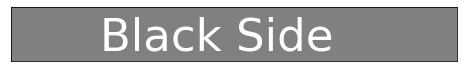

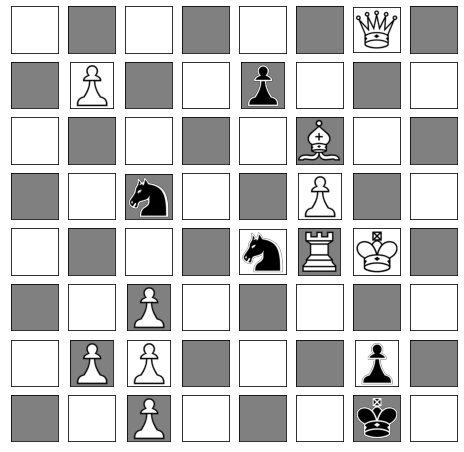

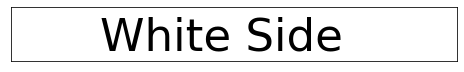

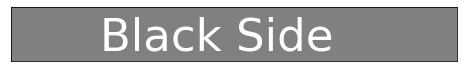

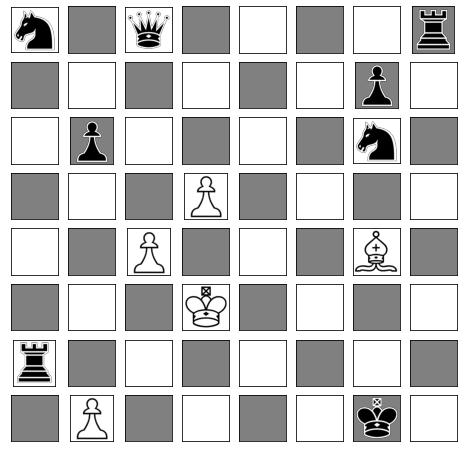

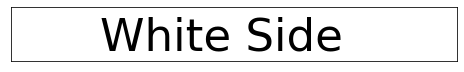

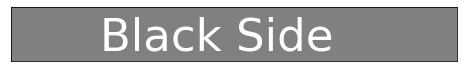

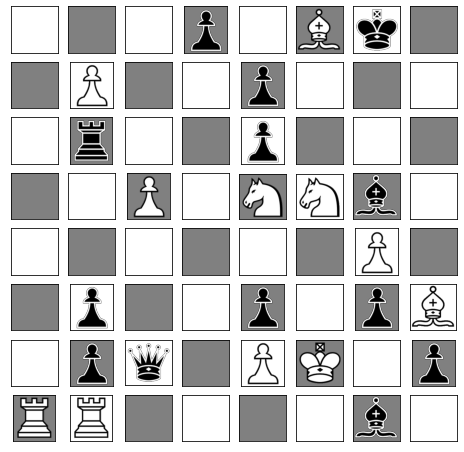

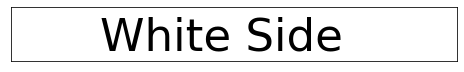

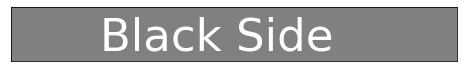

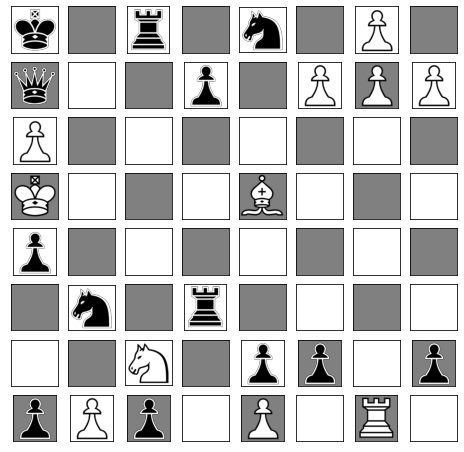

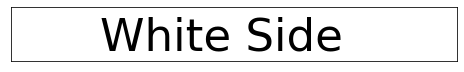

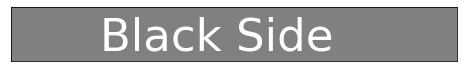

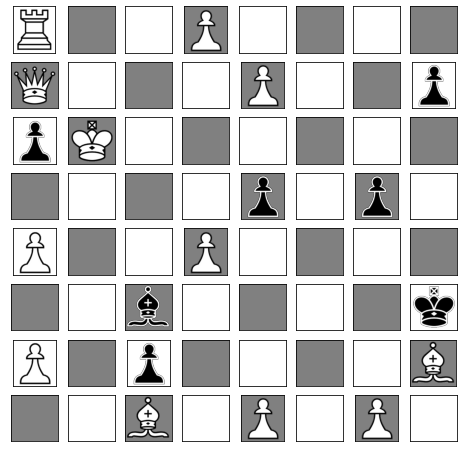

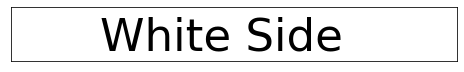

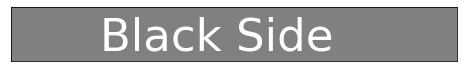

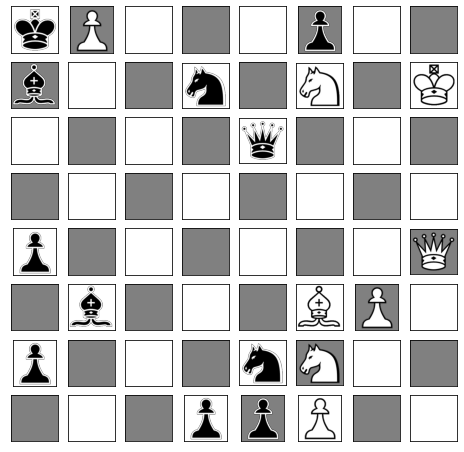

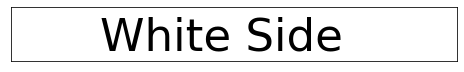

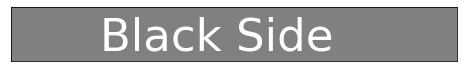

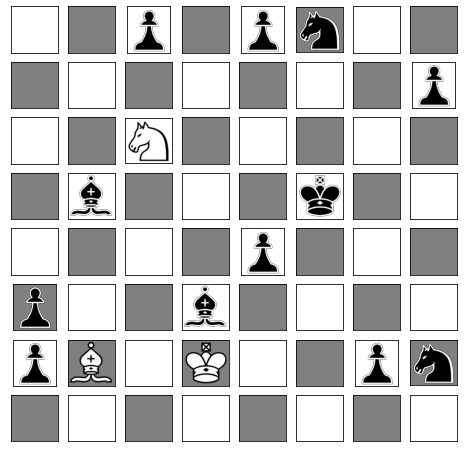

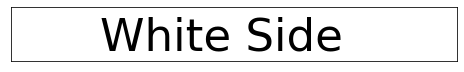

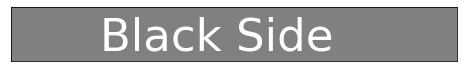

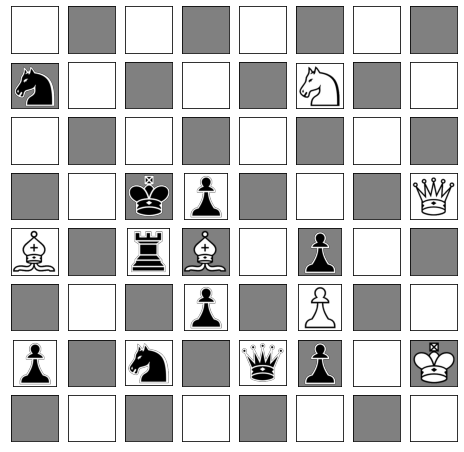

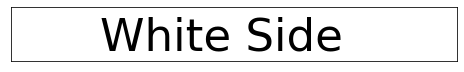

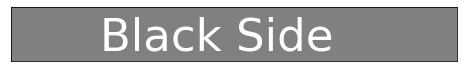

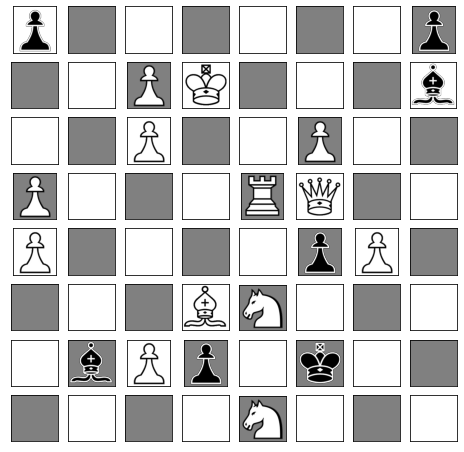

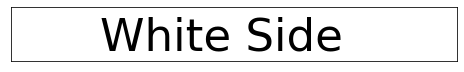

In [26]:
for n in range(9):
    chessBoardShow(training_images[n])

## ML Classification (Classical Version)

### Classical Nearest Centroid Neighbors 
References:

[k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[Nearest Centroid](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nearest_centroid.html#sphx-glr-auto-examples-neighbors-plot-nearest-centroid-py)

In [27]:
def nCen_train_test(training_data, testing_data, N, shrink, plot_testing=False):
    '''
    Train Nearest Centroid Neighbors algorithm. Plot results and accuracy. Output the best nCen.

    Inputs:
    training_data    := split training data, data array: [# red pieces, # blue pieces, winner] dims: (D*train_split) x 3
    testing_data     := split testing data, data array: [# red pieces, # blue pieces, winner] dims: (D*(1-train_split)) x 3
    N                := 1D dimension of board, s.t. board.shape = (N,N); used here for normalizing the data
    shrink           := list of shrink values to test, e.g., shrink=[0.0,0.1,0.5,0.9]
    plot_testing     := True or False value; plots the testing dataset with classifier bounds

    Outputs:
    Plots the nearest centroid decision boundary, training data, test data, and accuracy plots
    nCen             := nearest centroid object with the highest accuracy
    '''

    # Assign training/test data
    training_data[:,[0,1]]=training_data[:,[0,1]]/(N**2) # standardize data. Max pieces is N*N
    testing_data[:,[0,1]]=testing_data[:,[0,1]]/(N**2) # standardize data. Max pieces is N*N
    X_train = training_data[:,[0,1]] # training features
    y_train = training_data[:,2] # training labels
    X_test = testing_data[:,[0,1]] # testing features
    y_test = testing_data[:,2] # testing labels
    # =============================================================================

    # run accuracy with training data for k=k neighbors
    acc_list=[]
    nCen_list=[]
    for i in range(len(shrink)):

        # run kNN classification
        nCen_list.append(NearestCentroid(shrink_threshold=shrink[i])) # create k-NN object
        nCen_list[i].fit(X_train, y_train) # fit classifier decision boundary to training data
        # =============================================================================

        # plot classification boundary with training data
        meshres=50
        RED,BLUE=np.meshgrid(np.linspace(np.min([np.min(X_train[:,0]),np.min(X_test[:,0])]),np.max([np.max(X_train[:,0]),np.max(X_test[:,0])]),meshres),
                            np.linspace(np.min([np.min(X_train[:,1]),np.min(X_test[:,1])]),np.max([np.max(X_train[:,1]),np.max(X_test[:,1])]),meshres))
        boundary=nCen_list[i].predict(np.c_[RED.ravel(),BLUE.ravel()])
        plt.figure()
        plt.contourf(RED,BLUE,boundary.reshape(RED.shape),cmap='bwr',alpha=0.3)
        plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='bwr',edgecolor='k')
        plt.xlabel('# red pieces\n[normalized]')
        plt.ylabel('# blue pieces\n[normalized]')
        cbar=plt.colorbar()
        cbar.ax.set_ylabel('Winner')
        plt.title('Centroid Classification, shrink = '+str(shrink[i]))
        plt.show()
    
        # plot testing data
        if plot_testing == True:
            plt.figure()
            plt.contourf(RED,BLUE,boundary.reshape(RED.shape),cmap='bwr',alpha=0.3)
            testt=plt.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap='bwr',edgecolor='k')
            plt.xlabel('# red pieces\n[normalized]')
            plt.ylabel('# blue pieces\n[normalized]')
            plt.title('Testing Data, n = '+str(X_test.shape[0]))
            cbar=plt.colorbar(testt)
            cbar.ax.set_ylabel('Winner')
            plt.show()
        else:
            pass
        # =============================================================================

        # calculate accuracy with training data set
        predicted=nCen_list[i].predict(X_test) # calculate predicted label from training data
        acc=np.sum(predicted==y_test)/len(y_test) # calculate accuracy of where prediction is correct vs incorrect relative to actual labels
        acc_list.append(acc)
        print('shrink = ',shrink[i],'\nTraining Accuracy =',acc*100,'%\n','='*40,'\n\n')
    plt.figure()
    plt.plot(shrink,acc_list,marker='o')
    plt.xlabel('Centroid shrinking threshold')
    plt.xticks(shrink)
    plt.ylabel('Accuracy')
    plt.show()
    best_nCen=nCen_list[np.argmax(acc_list)]
    print('best shrink = ',shrink[np.argmax(acc_list)])
    return best_nCen

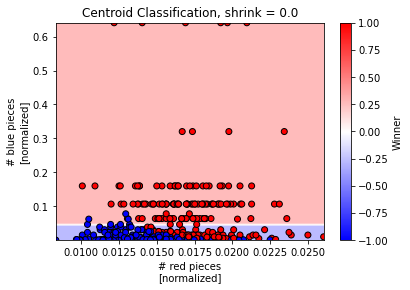

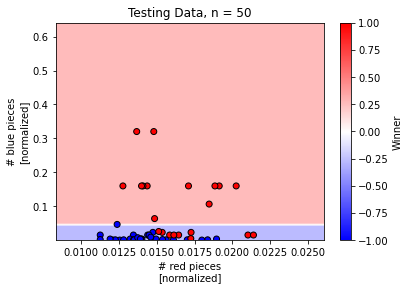

shrink =  0.0 
Training Accuracy = 82.0 %




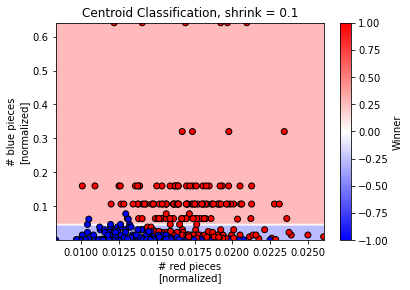

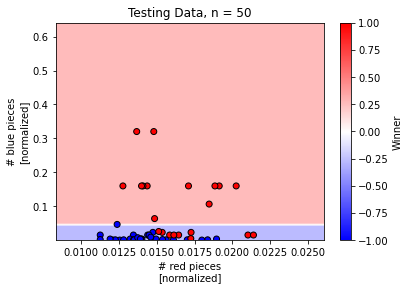

shrink =  0.1 
Training Accuracy = 82.0 %




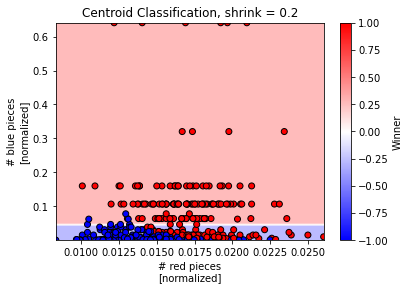

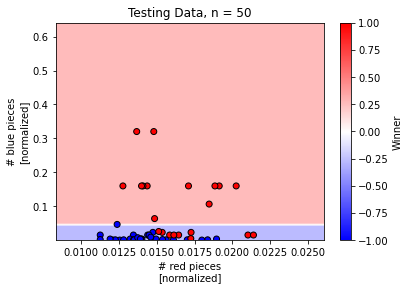

shrink =  0.2 
Training Accuracy = 82.0 %




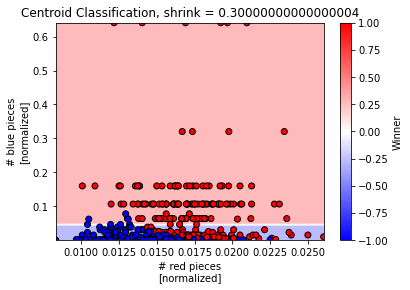

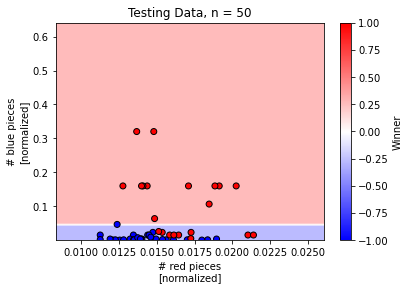

shrink =  0.30000000000000004 
Training Accuracy = 82.0 %




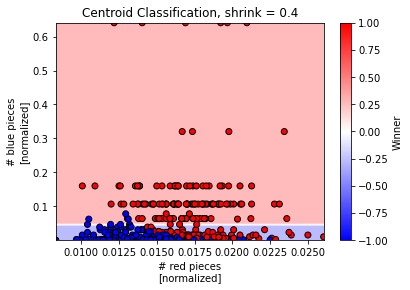

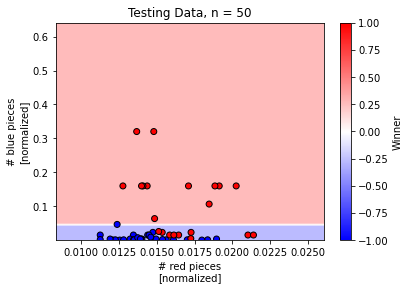

shrink =  0.4 
Training Accuracy = 82.0 %




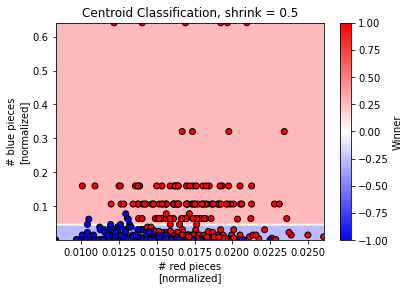

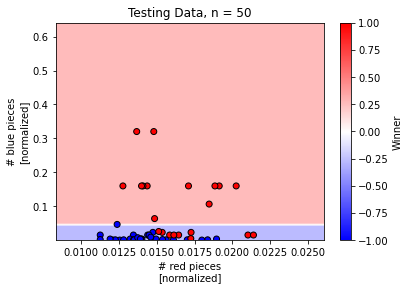

shrink =  0.5 
Training Accuracy = 82.0 %




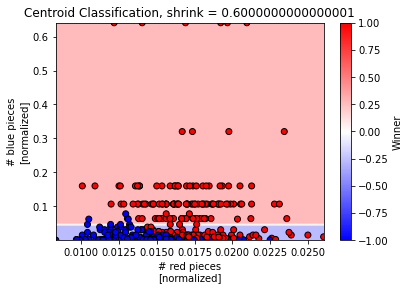

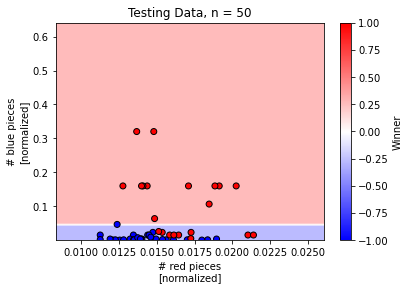

shrink =  0.6000000000000001 
Training Accuracy = 82.0 %




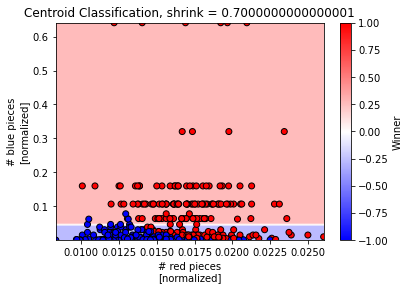

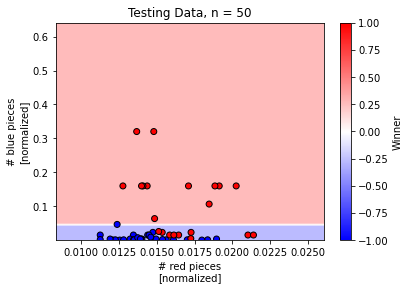

shrink =  0.7000000000000001 
Training Accuracy = 82.0 %




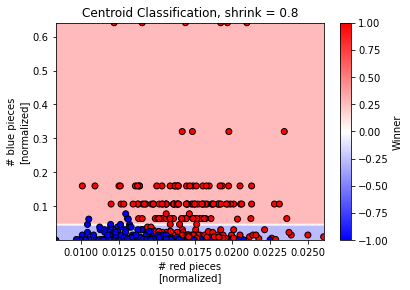

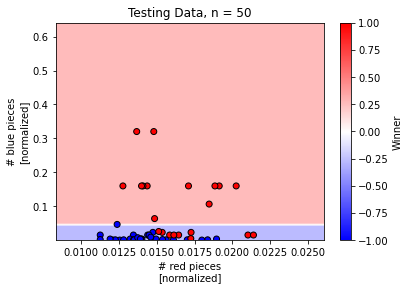

shrink =  0.8 
Training Accuracy = 82.0 %




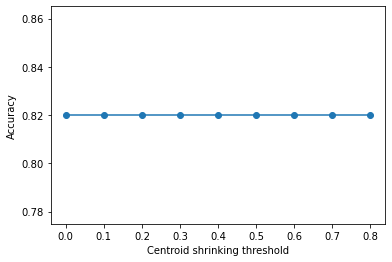

best shrink =  0.0


In [28]:
# generate best nearest centroid neighbors
best_nCen = nCen_train_test(training_data=training_data, testing_data=testing_data, N=N, shrink=list(np.arange(0.0,0.9,0.1)),plot_testing=True)

In [29]:
def player_prediction_classical(best_model,player_data):
    '''
    Outputs the classically predicted result of the 5 player games, not within the training dataset.

    Inputs:
    best_model    := NearestCentroid object
    player_data := generated data array: [# red pieces, # blue pieces, winner] dims: 5 x 3

    Outputs:
    cCompData     := list of 0 or 1 values. 1 == red wins, 0 == blue wins
    '''
    X_player_data=player_data[:,[0,1]]
    cCompData = best_model.predict(X_player_data)
    cCompData[cCompData==-1.]=0
    return list(cCompData.astype(int))

## ML Classification (Quantum Version)

### Quantum Nearest Centroid Neighbors 
References:

[Johri et al., "Nearest Centroid Classification on a Trapped Ion Quantum Computer," arXiv:2012.04145 \[quant-ph\], Dec. 2020.](https://arxiv.org/pdf/2012.04145.pdf)

In [30]:
# Unit-normalized vector helper
def normalize(x):
    return x / np.linalg.norm(x)

# Since in a space R^n there are n-1 RBS gates,
# in a 2-dimensional dataset (R^2), there is 1
# RBS parameter angle, as defined:
def theta_in_2d(x):
    epsilon = math.pow(10, -10)
    return math.acos((x[0] + epsilon) / (np.linalg.norm(x) + epsilon)) + epsilon

In [31]:
def estimation_circuit(x_theta, y_theta):
    # As defined in Johri et al. (III.A.1), an iRBS is functionally
    # identical in the distance estimation circuit to the RBS gate;
    # thus, the iRBS gate is defined in the QuantumCircuit class to
    # be used in the estimation circuit.

    # Unitary implementation (throws IonQ backend error)
    def irbs_unitary(theta):
        return UnitaryGate([[1, 0, 0, 0],
                            [0, np.cos(theta), complex(0,-np.sin(theta)), 0],
                            [0, complex(0, -np.sin(theta)), np.cos(theta), 0],
                            [0, 0, 0, 1]], label=f'iRBS({np.around(theta, 3)})')

    # Circuit implementation from figure 7 in Johri et al.
    def irbs(qc, theta, qubits):
        qc.rz(np.pi/2, qubits[1])
        qc.cx(qubits[1], qubits[0])
        qc.ry(np.pi/2 - 2 * theta, qubits[1])
        qc.rz(-np.pi/2, qubits[0])
        qc.cx(qubits[0], qubits[1])
        qc.ry(2 * theta - np.pi/2, qubits[1])
        qc.cx(qubits[1], qubits[0])
        qc.rz(-np.pi / 2, qubits[0])

    qc = QuantumCircuit(2,2)
    qc.x(0)
    irbs(qc, x_theta, [0, 1])
    irbs(qc, y_theta, [0, 1])
    qc.measure([0, 1], [0, 1])
    return qc

In [32]:
# Returns estimated distance as defined in Johri et al. (Equation 3)
def probability_uncorrected(result):
    counts = result.get_counts()
    shots = np.sum(list(counts.values()))
    if '10' in counts:
        return counts["10"]/shots
    else:
        return 0

def probability_corrected(result):
    counts = result.get_counts()
    corrected_counts = {}

    # Discard incorrect values (00, 11)
    if '10' in counts:
        corrected_counts['10'] = counts['10']
        corrected_counts['10'] = counts['10']
    if '01' in counts:
        corrected_counts['01'] = counts['01']

    shots = np.sum(list(corrected_counts.values()))
    if '10' in counts:
        return corrected_counts["10"]/shots
    else:
        return 0

def euclidian_distance(x, y, corrected=False):
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    x_square_norm = x_norm**2
    y_square_norm = y_norm**2

    x_theta = theta_in_2d(x)
    y_theta = theta_in_2d(y)

    ec = estimation_circuit(x_theta, y_theta)

    if backend.name() == "qasm_simulator":
        job = execute(ec, backend, shots=1000)
    else: # IonQ
        job = backend.run(ec, shots=1000)

    job_id = job.job_id()

    while job.status() is not JobStatus.DONE:
        print(job.status())
        time.sleep(1)
  
    result = job.result()

    if corrected:
        probability = probability_corrected(result)
    else:
        probability = probability_uncorrected(result)

    normalized_inner_product = math.sqrt(probability)

    return math.sqrt(x_square_norm + y_square_norm - 2*x_norm*y_norm*normalized_inner_product)

In [33]:
import random

# generate toy data: random N x N board
def generate_board(N):
    '''
    Generates a random board of dimensions N x N
    Inputs:
    N          := 1D dimension of board, s.t. board.shape = (N,N)

    Outputs:
    board      := flattened N x N array
    winner     := red wins == 1, blue wins == -1
    sum_red    := sum of red pieces
    sum_blue   := sum of blue pieces
    '''
    board=np.zeros((N*N))
    pieces=random.sample(range(1,N*N),1)[0]
    inds = random.sample(range(0,N*N),pieces) # pick random location to place pieces
    ratio = 1
    while ratio == 1: # safeguard to remove possiblility of ties
        for n in range(pieces):
            board[inds[n]]=random.sample([-1,1],1)[0] # make space blue or red
        sum_red = np.sum(board==1) # sum of 1 values (i.e., red pieces)
        sum_blue = np.sum(board==-1) # sum of -1 values (i.e., blue pieces)
        ratio = sum_red/sum_blue # find ratio
        if ratio > 1: # red wins
            winner = 1
        elif ratio < 1: # blue wins
            winner = -1
        else:
            pass
    return board, winner, sum_red, sum_blue

In [34]:
class QuantumNearestCentroid:
    def __init__(self):
        self.centroids = {}
  
    def centroid(self, x):
        return np.mean(x, axis=0)

    def fit(self, x, y):
        organized_values = {}
        for i, v in enumerate(y):
            if v in organized_values:
                organized_values[v].append(x[i])
        else:
            organized_values[v] = [x[i]]
        for v in organized_values:
            self.centroids[v] = self.centroid(organized_values[v])
        return self.centroids

    def predict(self, x):
        min_dist = np.inf
        closest_centroid = None
        for key, centroid in self.centroids.items():
            res = euclidian_distance(x, centroid)
            if res < min_dist:
                min_dist = res
                closest_centroid = key
        return closest_centroid

Prediction execution here :)

In [35]:
def player_prediction_quantum(best_model,player_data):
    '''
    Outputs the quantum predicted result of the 5 player games, not within the training dataset.

    Inputs:
    best_model  := NearestCentroid object
    player_data := generated data array: [# red pieces, # blue pieces, winner] dims: 5 x 3

    Outputs:
    cCompData   := list of 0 or 1 values. 1 == red wins, 0 == blue wins
    '''
    X_player_data=player_data[:,[0,1]]
    qCompData = []
    for i in range(5):
        qCompData.append(best_model.predict(X_player_data[i]))
    qCompData[qCompData==-1.]=0
    return list(qCompData)

Quantum model analysis :) (this isn't necessary to run for the game)

In [36]:
def quantum_train_test(training_data, testing_data, N, plot_testing=False):
    '''
    Train Nearest Centroid Neighbors algorithm. Plot results and accuracy. Output the best nCen.

    Inputs:
    training_data    := split training data, data array: [# red pieces, # blue pieces, winner] dims: (D*train_split) x 3
    testing_data     := split testing data, data array: [# red pieces, # blue pieces, winner] dims: (D*(1-train_split)) x 3
    N                := 1D dimension of board, s.t. board.shape = (N,N); used here for normalizing the data
    shrink           := list of shrink values to test, e.g., shrink=[0.0,0.1,0.5,0.9]
    plot_testing     := True or False value; plots the testing dataset with classifier bounds

    Outputs:
    Plots the nearest centroid decision boundary, training data, test data, and accuracy plots
    nCen             := nearest centroid object with the highest accuracy
    '''

    # Assign training/test data
    X_train = training_data[:,[0,1]] # training features
    y_train = training_data[:,2] # training labels
    X_test = testing_data[:,[0,1]] # testing features
    y_test = testing_data[:,2] # testing labels
    # =============================================================================

    model = QuantumNearestCentroid()

    centroid = model.fit(X_train.tolist(), y_train.flatten().tolist())
    print(centroid)

    meshres=30
    RED,BLUE=np.meshgrid(np.linspace(np.min([np.min(X_train[:,0]),np.min(X_test[:,0])]),np.max([np.max(X_train[:,0]),np.max(X_test[:,0])]),meshres),
                      np.linspace(np.min([np.min(X_train[:,1]),np.min(X_test[:,1])]),np.max([np.max(X_train[:,1]),np.max(X_test[:,1])]),meshres))
    print(len(np.c_[RED.ravel(),BLUE.ravel()]))
    boundary=[]
    for i, v in enumerate(np.c_[RED.ravel(),BLUE.ravel()]):
        print(f"{i} : {v.tolist()}")
        res = model.predict(list(v))
        print(res)
        boundary.append(res)
    print(boundary)
    boundary = np.array(boundary)
    plt.figure()
    plt.contourf(RED,BLUE,boundary.reshape(RED.shape),cmap='bwr',alpha=0.3)
    plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='bwr',edgecolor='k')
    plt.xlabel('# red pieces\n[normalized]')
    plt.ylabel('# blue pieces\n[normalized]')
    cbar=plt.colorbar()
    cbar.ax.set_ylabel('Winner')
    plt.title('Centroid Classification')
    plt.show()

    # plot testing data
    if plot_testing == True:
        plt.figure()
        plt.contourf(RED,BLUE,boundary.reshape(RED.shape),cmap='bwr',alpha=0.3)
        testt=plt.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap='bwr',edgecolor='k')
        plt.xlabel('# red pieces\n[normalized]')
        plt.ylabel('# blue pieces\n[normalized]')
        plt.title('Testing Data, n = '+str(X_test.shape[0]))
        cbar=plt.colorbar(testt)
        cbar.ax.set_ylabel('Winner')
        plt.show()
    else:
        pass
    # =============================================================================

    # calculate accuracy with training data set
    predicted=[] # calculate predicted label from training data
    for v in X_test:
        predicted.append(model.predict(v))
    predicted = np.array(predicted)
    acc=np.sum(predicted==y_test)/len(y_test) # calculate accuracy of where prediction is correct vs incorrect relative to actual labels
    print('Training Accuracy =',acc*100,'%\n','='*40,'\n\n')

    return model

def quantum_train(training_data, testing_data, N):
    # Assign training/test data
    X_train = training_data[:,[0,1]] # training features
    y_train = training_data[:,2] # training labels
    X_test = testing_data[:,[0,1]] # testing features
    y_test = testing_data[:,2] # testing labels

    model = QuantumNearestCentroid()

    centroid = model.fit(X_train.tolist(), y_train.flatten().tolist())

    return model

In [37]:
# Uncomment below if you want to run the analysis
# best_quantum = quantum_train_test(training_data=training_data, testing_data=testing_data, N=N, plot_testing=True)

# generate best nearest centroid neighbors
best_quantum = quantum_train(training_data=training_data, testing_data=testing_data, N=N)

## Game Logic & UI

In [38]:
compData =  []
compResults = []

In [39]:
def generateCompData(cData = [0,0,0,0,0], qData = [0,0,0,0,0], gData = [0, 0, 0, 0,]): 
    global compData
    global compResults

    ''' Here we take the 2d array gData and transpose it '''
    pgData = pd.DataFrame(gData).T.values.tolist()
    pgData = [0 if x==-1.0 else 1 for x in pgData[2]]

    '''
        These reset the compData and compResults array so there are no errors 
        with the runtime 
    '''
    compData = [
                        [0,0,0,0], # Storing what the [Q, C, H, G] say the answer is.
                        [0,0,0,0],
                        [0,0,0,0],
                        [0,0,0,0],
                        [0,0,0,0]
    ]
    compResults = [
                        [0,0,0], # Storing [QvG, HvG, CvG]
                        [0,0,0],
                        [0,0,0],
                        [0,0,0],
                        [0,0,0]
    ]

    ''' 
    The entirety of this function is to setup the enviroment for future functions
    '''
    qCompData = qData # this will be the data from the QML on the 5 boards given
    cCompData = cData # this will be the data from the Classical on the 5 boards given
    gCompData = pgData # this is the ground truth answers

    ''' 
        These take the original qCompData and cCompData arrays and put them 
        together in the compData array for parrsing later in the program 
    '''
    count = 0
    for i in qCompData: 
        compData[count][1] = int(i)
        count += 1
    count = 0
    for i in cCompData:
        compData[count][0] = int(i)
        count += 1
    count = 0
    for i in gCompData:
        compData[count][3] = int(i)
        count += 1

In [40]:
def finalizeCompResults():
    ''' 
    The entirety of this function is to check if the quatum model and 
    human match the conventional model
    '''
    global compData
    global compResults
    count = 0
    for i in compData:
        if i[3] == i[0]: # this is for the C v. G
            compResults[count][1] = 1
        if i[3] == i[1]: # this is for the Q v. G
            compResults[count][0] = 1
        if i[3] == i[2]: # this is for the H v. G
            compResults[count][2] = 1
        count += 1

In [41]:
def showCompResults():
    ''' 
    The entirety of this function is to display to the user which problem they
    or the quantum computer got correct in a visually pleasing way
    '''
    global compResults
    global compData

    data = [
                        [0,0,0,0],
                        [0,0,0,0],
                        [0,0,0,0],
                        [0,0,0,0],
                        [0,0,0,0]
    ]
    dataColors = [
                        ["#a2cffe",0,0,0],
                        ["#a2cffe",0,0,0],
                        ["#a2cffe",0,0,0],
                        ["#a2cffe",0,0,0],
                        ["#a2cffe",0,0,0]
    ]

    ''' 
    This next for loop checks the compResults array and sets the values of data
    and dataColors accordingly
    '''
    count = 0
    # print(compResults)
    for i in compResults:
        if i[0] == 1: # Q v. G
            data[count][3] = compData[count][1]
            dataColors[count][3] = "palegreen"
        else:
            dataColors[count][3] = "#cf6275"

        if i[2] == 1: # Human v. G
            data[count][1] = compData[count][2]
            dataColors[count][1] = "palegreen"
        else:
            dataColors[count][1] = "#cf6275"

        if i[1] == 1: # C v. G
            data[count][2] = compData[count][0]
            dataColors[count][2] = "palegreen"
        else:
            dataColors[count][2] = "#cf6275"

        data[count][0] = compData[count][3]
        count += 1
    print(data)
    for i in range(0,5):
        data[i] = ["Black" if x==1 else "White" for x in data[i]]
    print(data)
    ''' 
    This section below sums the amount of correct answers from both the human
    and quantum computer
    '''
    Sum = [sum(x) for x in zip(*compResults)]
    winner = ". . . wait what?!?!?! it was a tie! Well, I guess no one"
    if (Sum[0] < Sum[1]) and (Sum[0] < Sum[2]):
        winner = "Human"
    elif (Sum[1] < Sum[0]) and (Sum[1] < Sum[2]):
        winner = "Quantum Computer"
    elif (Sum[2] < Sum[1]) and (Sum[2] < Sum[0]):
        winner = "Classical Computer"
    
    ''' 
    This section below displays the data formated above and who the winner of the 
    game is
    '''
    fig, ax = plt.subplots(1,1)
    column_labels=["Truth", "Human v. Truth", "Classical v. Truth", "Quantum v. Truth"]
    plt.title("Who won, a quantum computer or a human? Turns out the " + winner + " is better!")
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=data,
                     colLabels = column_labels,
                     cellColours = dataColors,
                     loc = "center",
                     cellLoc='center')
    plt.show()

In [42]:
def showProblem(array):
    ''' 
    This function is used to display the game board for the user to evaluate
    '''
    global compData
    # N = 8 # board dimensions: N x N
    # board = array
    # board = board.reshape(N,N)

    plt.axis('off')
    # plt.title("Does Black or White have a game-state advantage this turn?")
    # plt.imshow(board,cmap='bwr')
    chessBoardShow(array)
    plt.show()

In [44]:
def playersMove(roundNum):
    ''' 
    This function is used to initialize the user to input an answer for the 
    game board
    '''
    global compData
    while True:
        print('\033[1m'+'GAME #',str(roundNum+1)+'/5'+'\033[0m')
        print('_'*100)
        print('\033[1m'+'WHICH PLAYER HAS THE GAME-STATE ADVANTAGE THIS TURN?'+'\033[0m')
        print('Hint: Game-state advantage is computed based on which player has a higher total\n',
                    'piece value minus the value of the best piece the opposing player can take this turn.\n',
                    'Note: There CANNOT be a tie.')
        print('_'*100,'\n') 
        print("Does black or white have the advantage? (b/w): ")
        playerChoice = input("").lower()
        if playerChoice == "b":
            playerChoice = 1
            break
        elif playerChoice == "w":
            playerChoice = 0
            break
    compData[roundNum][2] = playerChoice

# Play the Game!

[[0, 0, 0, 0], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]
[['White', 'White', 'White', 'White'], ['Black', 'Black', 'Black', 'Black'], ['Black', 'Black', 'Black', 'Black'], ['Black', 'Black', 'Black', 'Black'], ['Black', 'Black', 'Black', 'Black']]


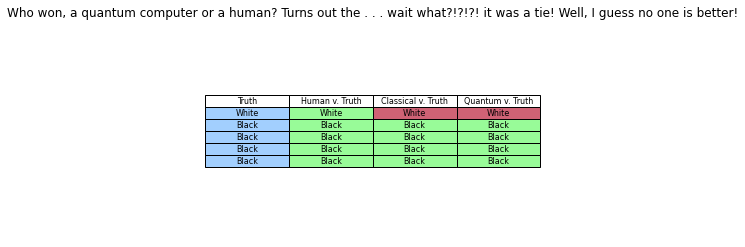

Would you like to play again? (y/n): 


In [ ]:
clear_output(wait=True)
newGame = True
while newGame:
    # Generate 5 boards for the player to play
    player_data_5, player_images_5, __, __ =generate_data(D=5,train_split=1)
    cCompData = player_prediction_classical(best_model=best_nCen,player_data=player_data_5)
    # qCompData = player_prediction_quantum(best_model=best_quantum,player_data=player_data_5)
    qCompData=[1,1,1,1,1]
    generateCompData(cCompData, qCompData, player_data_5)
    clear_output(wait=True)

    # Start the game!
    for i in range(0, 5):
        
        showProblem(player_images_5[i])
        playersMove(i)
        clear_output(wait=True)
    finalizeCompResults()
    showCompResults()
    while True:
        print("Would you like to play again? (y/n): ")
        playerChoice = input("").lower()
        if playerChoice == "y":
            clear_output(wait=True)
            break
        elif playerChoice == "n":
            clear_output(wait=True)
            newGame = False
            break